In [1]:
import csv
import os

import math
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc

# Load Data
Load y Data

In [2]:
# load y data
participant_info_df = pd.read_csv("../Model_Input/participant_info.csv")
participant_info_df.sort_values('id', inplace=True) #make sure, its alphabetically sorted

participants = {}

participants = participant_info_df.set_index('id')['ASC'].to_dict()

# rename participant ids to their corresponding dataframe name
for k in list(participants.keys()):
    new_key = k + "_concat.csv"
    participants[new_key] = participants.pop(k)
#print(participants)

Load X Data

In [3]:
print("Number of participants:", len(participants))
print("Number of participants with ASC:", sum(participants.values()))
print("Number of participants with ASC:", sum([1 for i in participants.values() if i==0]))

Number of participants: 164
Number of participants with ASC: 83
Number of participants with ASC: 81


In [4]:
# Load X Data
no_median_flag = True
method_frames = {}

for (root, dirs, file) in os.walk("../Model_Input/parted_video"):
    for f in file:
        if ".csv" in f:
            path = root + "/" + f
            df = pd.read_csv(path, header=[0,1])
            
            # Rename the first column to 'id' using its index
            df.columns = pd.MultiIndex.from_tuples([("id", np.nan)] + list(df.columns[1:]))
            # get rid of unknown participant
            df = df.drop(df[df[('id', np.nan)] == 'pre-91-020_part_1_concat.csv'].index)

            if no_median_flag:
                df = df.drop([col for col in df.columns if '_median' in col], axis=1)
            
            method_frames[f] = df

print(method_frames.keys())

dict_keys(['libreface_stats_parted.csv', 'me_graph_stats_parted.csv', 'openframe_stats_parted.csv', 'libreface_stats_parted-checkpoint.csv'])


In [5]:
print(method_frames["me_graph_stats_parted.csv"].columns)

MultiIndex([(         'id',                   nan),
            (   'AU1_mean',         'neu_actress'),
            (   'AU2_mean',         'neu_actress'),
            (   'AU4_mean',         'neu_actress'),
            (   'AU5_mean',         'neu_actress'),
            (   'AU6_mean',         'neu_actress'),
            (   'AU7_mean',         'neu_actress'),
            (   'AU9_mean',         'neu_actress'),
            (  'AU10_mean',         'neu_actress'),
            (  'AU11_mean',         'neu_actress'),
            ...
            ('AU20_median', 'disgust_participant'),
            ('AU22_median', 'disgust_participant'),
            ('AU23_median', 'disgust_participant'),
            ('AU24_median', 'disgust_participant'),
            ('AU25_median', 'disgust_participant'),
            ('AU26_median', 'disgust_participant'),
            ('AU27_median', 'disgust_participant'),
            ('AU32_median', 'disgust_participant'),
            ('AU38_median', 'disgust_participant

# Run Cross-Validation

### LOOCV

In [6]:
def loocv(data_features, labels):
    # create loocv procedure
    cv = LeaveOneOut()
    # create model instance
    xbst = XGBClassifier() #(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    
    # evaluate model
    base_scores = cross_val_predict(xbst, data_features, labels, cv=cv, n_jobs=-1) # 'precision', 'recall'
    
    return base_scores

### Inner LOOCV

##### Clean and test data

In [7]:
def get_data(method_name):
    df = method_frames[method_name]
    
    # make sure it's sorted by participant in alph. order
    df = df.sort_values(('id', np.nan))
    cleaned_data = df #.drop(columns=["id"])
    return cleaned_data


Test if participant labels are matching with data:

In [8]:
# Test if participant labels are correct with data:

#print(method_frames['openframe_stats_parted.csv'].iloc[0])
#method_frames['openframe_stats_parted.csv'].info()
data = get_data('openframe_stats_parted.csv')
zipped = zip(list(data[("id", np.nan)]), list(participants.keys()))
for l1,l2 in zipped:
    #print(l1)
    if not l1 in l2:
        print(f"{l1} != {l2}")
print("If no line was printed, the data X and label y match")

If no line was printed, the data X and label y match


### Replicate Openface stats as in paper

In [9]:
X_of = get_data('openframe_stats_parted.csv')
labels = np.array(list(participants.values()))

In [10]:
# Reset the index to ensure it's numerical
X_of.reset_index(drop=True, inplace=True)
# Drop the irrelevant index column
X_of = X_of.drop(columns=[('id', np.nan)])

# Drop median and var columns where only true/false values are awailable
columns_to_drop = [col for col in X_of.columns if '_c_median' in col[0] or '_c_var' in col[0]]
#print(columns_to_drop)
X_of = X_of.drop(columns=columns_to_drop)

In [11]:
# report performance
of_loocv_predictions = loocv(X_of, labels)

In [12]:
of_acc = accuracy_score(labels, of_loocv_predictions)
of_prec = precision_score(labels, of_loocv_predictions, average="binary")
of_rec = recall_score(labels, of_loocv_predictions, average="binary")

print(f"Openface:\nAcc:\t{of_acc}\nPrec:\t{of_prec}\nRecall:\t{of_rec}")

Openface:
Acc:	0.7134146341463414
Prec:	0.7142857142857143
Recall:	0.7228915662650602


Openface without binary values:

In [13]:
# drop binary values
columns_to_drop = [col for col in X_of.columns if '_c' in col[0]]
X_of_intensity_only = X_of.drop(columns=columns_to_drop)

In [14]:
of_loocv_intensity_predictions = loocv(X_of_intensity_only, labels)

In [15]:
of_acc = accuracy_score(labels, of_loocv_intensity_predictions)
of_prec = precision_score(labels, of_loocv_intensity_predictions, average="binary")
of_rec = recall_score(labels, of_loocv_intensity_predictions, average="binary")

print(f"Openface:\nAcc:\t{of_acc}\nPrec:\t{of_prec}\nRecall:\t{of_rec}")

Openface:
Acc:	0.7378048780487805
Prec:	0.7325581395348837
Recall:	0.7590361445783133


### LibreFace

In [16]:
X_lf = get_data('libreface_stats_parted.csv')
labels = np.array(list(participants.values()))

In [17]:
# Reset the index to ensure it's numerical
X_lf.reset_index(drop=True, inplace=True)
# Drop the irrelevant index column
X_lf = X_lf.drop(columns=[('id', np.nan)], errors='ignore')

In [18]:
# report performance
lf_loocv_predictions = loocv(X_lf, labels)

In [19]:
lf_acc = accuracy_score(labels, lf_loocv_predictions)
lf_prec = precision_score(labels, lf_loocv_predictions, average="binary")
lf_rec = recall_score(labels, lf_loocv_predictions, average="binary")

print(f"Libreface:\nAcc:\t{lf_acc}\nPrec:\t{lf_prec}\nRecall:\t{lf_rec}")

Libreface:
Acc:	0.6219512195121951
Prec:	0.6265060240963856
Recall:	0.6265060240963856


Libreface with only intensity values:

In [20]:
columns_to_drop = [col for col in X_lf.columns if '_d' in col[0]]
X_lf_intensity_only = X_lf.drop(columns=columns_to_drop)

In [21]:
lf_loocv_intensity_predictions = loocv(X_lf_intensity_only, labels)

In [22]:
lf_acc = accuracy_score(labels, lf_loocv_intensity_predictions)
lf_prec = precision_score(labels, lf_loocv_intensity_predictions, average="binary")
lf_rec = recall_score(labels, lf_loocv_intensity_predictions, average="binary")

print(f"Libreface with only intensity values:\nAcc:\t{lf_acc}\nPrec:\t{lf_prec}\nRecall:\t{lf_rec}")

Libreface with only intensity values:
Acc:	0.6158536585365854
Prec:	0.6190476190476191
Recall:	0.6265060240963856


#### ME-Graph

In [23]:
X_me = get_data('me_graph_stats_parted.csv')

In [24]:
zipped = zip(list(X_me[("id", np.nan)]), list(participants.keys()))
for l1,l2 in zipped:
    #print(l1)
    if not l1 in l2:
        print(f"{l1} != {l2}")
print("If no line was printed, the data X and label y match")

If no line was printed, the data X and label y match


In [25]:
# Reset the index to ensure it's numerical
X_me.reset_index(drop=True, inplace=True)
# Drop the irrelevant index column
X_me = X_me.drop(columns=[('id', np.nan)], errors='ignore')
# Drop any column with predictions
X_me_original = X_me.drop(columns=[col for col in X_me.columns if 'prediction' in col[1]])

print(len(X_me_original.columns))

648


In [26]:
#me_loocv_scores = loocv(X_me, labels)
me_loocv_predictions = loocv(X_me_original, labels)

In [27]:
me_acc = accuracy_score(labels, me_loocv_predictions)
me_prec = precision_score(labels, me_loocv_predictions, average="binary")
me_rec = recall_score(labels, me_loocv_predictions, average="binary")

print(f"ME-Gaph:\nAcc:\t{me_acc}\nPrec:\t{me_prec}\nRecall:\t{me_rec}")

ME-Gaph:
Acc:	0.6341463414634146
Prec:	0.6493506493506493
Recall:	0.6024096385542169


Check if it performs better with less AUs

In [28]:
list_AUs = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU9', 'AU12', 'AU15', 'AU17', 'AU20', 'AU25', 'AU26']

In [29]:
filtered_columns = [col for col in X_me.columns if any(substring in col[0] for substring in list_AUs)]
X_me_filtered = X_me[filtered_columns]
print(len(filtered_columns))

552


In [30]:
me_loocv_filtered_predictions = loocv(X_me_filtered, labels)

In [31]:
me_acc = accuracy_score(labels, me_loocv_filtered_predictions)
me_prec = precision_score(labels, me_loocv_filtered_predictions, average="binary")
me_rec = recall_score(labels, me_loocv_filtered_predictions, average="binary")

print(f"ME-Gaph with only {list_AUs}:\nAcc:\t{me_acc}\nPrec:\t{me_prec}\nRecall:\t{me_rec}")

ME-Gaph with only ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU9', 'AU12', 'AU15', 'AU17', 'AU20', 'AU25', 'AU26']:
Acc:	0.6524390243902439
Prec:	0.6625
Recall:	0.6385542168674698


## ROC

In [39]:
def all_roc_graph(y_true, predictions, name): 
   
    plt.figure(figsize=(12, 8))  
    pred=0
    fz=22 #16
    lw=3 #1.5
    sns.set_style("white") 
    
    colors=[ (0, 128, 128),  (0, 0, 128), (200, 128, 0), (128, 0, 0), (31, 119, 180), (255, 127, 14)]
    linestyle = ['-', '-.', '--', ':', '-.', '-', '--', ':']
    markers = [' ', ' ', ' ', ' ', 'o', 'x']
    
    plt.plot([-0.01, 1.01], [-0.01, 1.01], color=(0 / 255., 0 / 255., 0 / 255.), 
             linestyle='-',lw=0.5)
    
    for i in range(len(colors)): 
        r, g, b = colors[i]
        colors[i] = (r / 255., g / 255., b / 255.) 
        
    for key in predictions:
        
        fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_true, predictions[key], drop_intermediate=False)
        roc_auc_nn = auc(fpr_nn, tpr_nn)

        plt.plot(fpr_nn, tpr_nn, label=key + ': AUC = %0.2f' % (roc_auc_nn),
                 lw=lw,
                 linestyle=linestyle[pred],
                 color=colors[pred],
                 marker=markers[pred]
                )    
        pred=pred+1      
        
   
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.yticks(fontsize=fz)    
    plt.xticks(fontsize=fz)  
    plt.xlabel('False-Positive-Rate', fontsize=fz)
    plt.ylabel('True-Positive-Rate', fontsize=fz)
    plt.title('Receiver Operating Characteristic', fontsize=fz)
    plt.legend(loc='lower right', fontsize=fz-2)   
    plt.savefig('ROC_' + name +'.png', format='png')
    plt.savefig('ROC_' + name +'.pdf', format='pdf')
    plt.show()   
    plt.close()

In [34]:
def test_for_roc(X, y):

    model = XGBClassifier()
    loo = LeaveOneOut()
    y_true = []
    y_scores = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train your model
        model.fit(X_train, y_train)
        
        # Get the predicted probabilities
        y_score = model.predict_proba(X_test)[:, 1]
    
        y_true.append(y_test[0])
        y_scores.append(y_score[0])
   
    return y_true, y_scores

In [36]:
predictions_roc = {}
explained = {}
# ME Graph
y_true, predictions_roc["ME-Graph"] = test_for_roc(X_me, labels)
# Libreface
y_true, predictions_roc["Libreface"] = test_for_roc(X_lf, labels)
# ME Graph
y_true, predictions_roc["Openface"] = test_for_roc(X_of, labels)

In [37]:
# ME Graph
y_true, predictions_roc["ME-Graph-original"] = test_for_roc(X_me_original, labels)
_, predictions_roc["ME-Graph (reduced)"] = test_for_roc(X_me_filtered, labels)

_, predictions_roc["Openface (intensity)"]  = test_for_roc(X_of_intensity_only, labels)

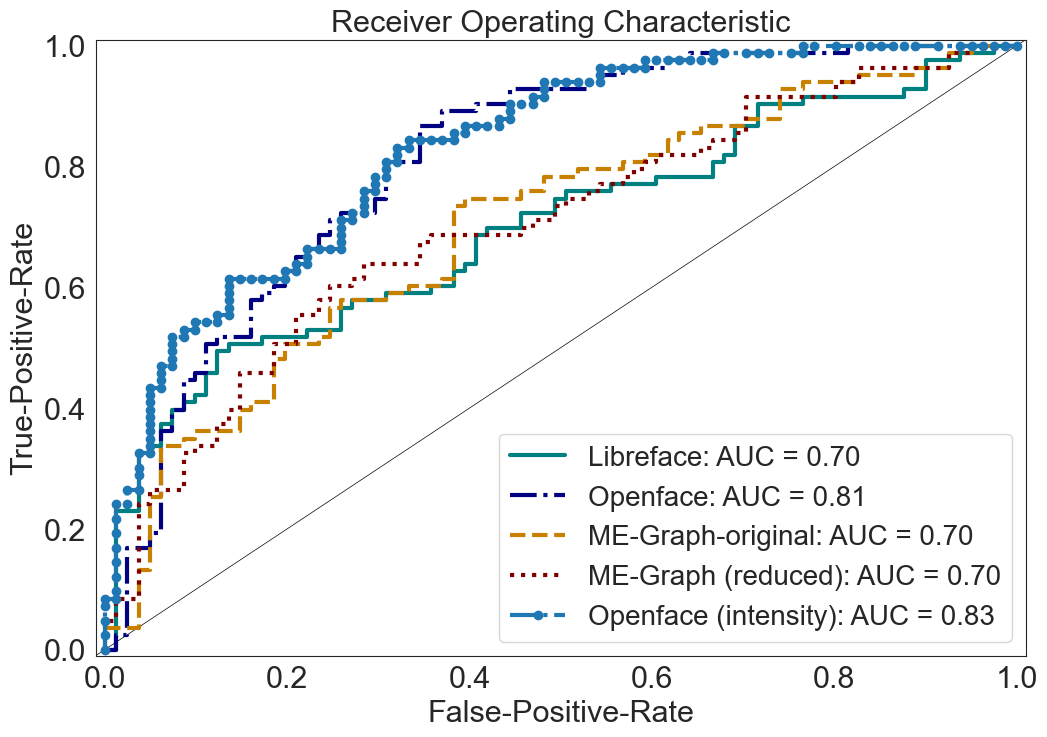

In [41]:
del predictions_roc["ME-Graph"]
all_roc_graph(y_true, predictions_roc, 'ROC_2')